# Projeto - Machine Learning I

In [1]:
# Análise exploratória e visualição
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
sns.set(style="darkgrid",font_scale=1.5)

# Warnings
import warnings
warnings.filterwarnings("ignore")


# Modelos de classificação
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Pré-processamento
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# Métricas de avaliação
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
      f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

# Geração de dados sintéticos
from imblearn.over_sampling import SMOTE

# Carregamento de dados e considerações iniciais

In [2]:
df = pd.read_csv("Churn_Modelling.csv")

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
print(f'Total de linhas: {df.shape[0]}')
print(f'Total de colunas: {df.shape[1]}')

Total de linhas: 10000
Total de colunas: 14


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


<font color = red>
    
- Explicar o significado das variáveis

### Dados duplicados

In [6]:
df[df.duplicated()].shape

(0, 14)

In [7]:
print(f'Número de registros duplicados: {df.duplicated().sum()}')

Número de registros duplicados: 0


### Dados faltantes

In [8]:
df.isnull().sum().to_frame().rename(columns = {0: "Número de campos vazios"})

,Número de campos vazios
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


- Não há dados faltantes no dataframe.

# Análise Exploratória

### Eliminando colunas desnecessárias para a análise

In [9]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [10]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [11]:
alvo = 'Churned'
df.rename(columns={'Exited': alvo}, inplace=True)
#df['Churned'].replace({0:'No', 1: 'Yes'}, inplace=True)
etiquetas = ['No','Yes']
cores = ['#3274A1','#EB3E5E']

## Distribuição da classe alvo (Churned)

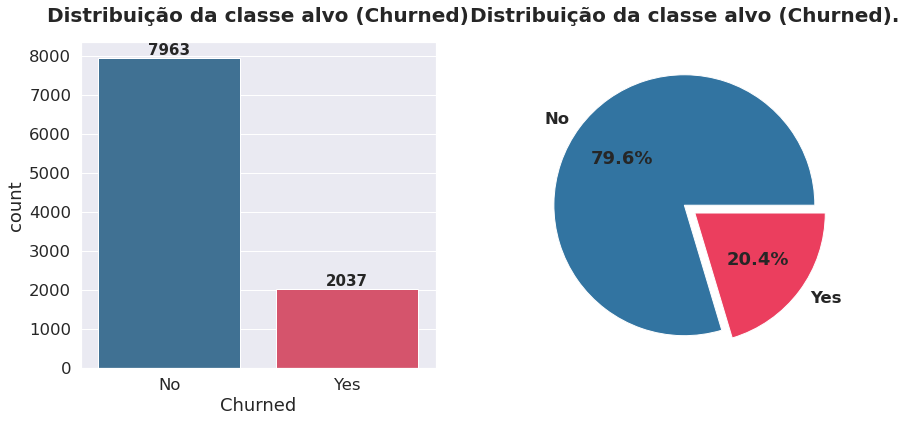

In [12]:
count = df[alvo].value_counts()

#sns.set_theme(style="whitegrid")
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
ax=sns.countplot(x=df[alvo].replace({0:'No', 1: 'Yes'}),palette=cores, order=etiquetas)
ax.bar_label(ax.containers[0],fontweight="black",size=15)
plt.title(f"Distribuição da classe alvo ({alvo})",fontweight="black",size=20,pad=20)

plt.subplot(1,2,2)
plt.pie(count.values, labels=etiquetas,
        autopct="%1.1f%%", colors= cores,
        textprops={"fontweight":"black"},explode=[0,0.1])
plt.title(f"Distribuição da classe alvo ({alvo}).",fontweight="black",size=20,pad=20)
plt.show()

- A base de dados apresenta um desbalanceamento bastante acentuado.
- Mais adiante, no momento de construir um modelo de Machine Learning, possivelmente será necessário efetuar algum processo de balanceamento (ex: oversampling, undersampling, SMOTE)

Funções auxiliares

In [13]:
# Função para construir gráficos agrupados de acordo com colunas categóricas
def countplot(column, df):
    plt.figure(figsize=(15,5))
    ax = sns.countplot(x=column, data=df, hue=alvo, palette=cores)
    for value in ax.patches:
        percentage = "{:.1f}%".format(100*value.get_height()/len(df[column]))
        x = value.get_x() + value.get_width() / 2 - 0.05
        y = value.get_y() + value.get_height()
        ax.annotate(percentage, (x,y), fontweight="black",size=15)

    plt.title(f"Distribuição da classe alvo de acordo com a categoria '{column}' ",fontweight="black",size=20,pad=20)
    plt.legend(labels=etiquetas)
    plt.show()

In [14]:
def countplot_group(column, df, group):
    df_column = df.groupby(column)

    plt.figure(figsize=(15,5))
    ax = sns.countplot(x=column, data=df_column.get_group(group), hue=alvo, palette=cores)
    for value in ax.patches:
        percentage = "{:.1f}%".format(100*value.get_height()/len(df_column.get_group(group)))
        x = value.get_x() + value.get_width() / 2 - 0.05
        y = value.get_y() + value.get_height()
        ax.annotate(percentage, (x,y), fontweight="black",size=15)

    plt.title(f"Distribuição da classe alvo dentro do grupo '{group}' ",fontweight="black",size=20,pad=20)
    plt.legend(labels=etiquetas)
    plt.show()

## Distribuição da classe alvo por gênero

In [15]:
df["Gender"].value_counts().to_frame().T

,Male,Female
Gender,5457,4543


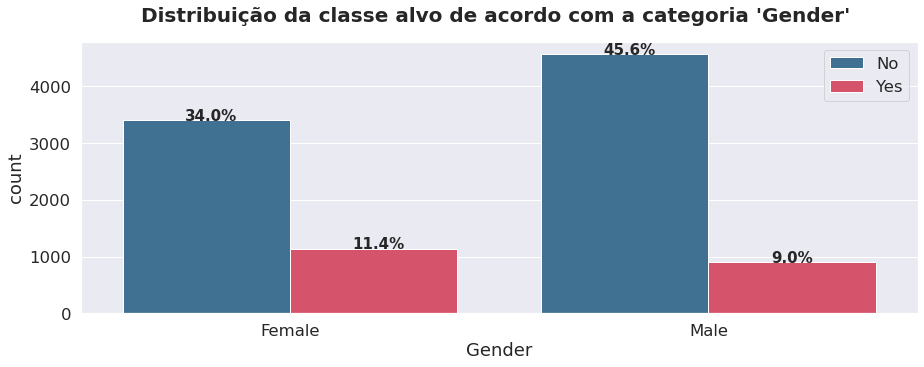

In [16]:
countplot("Gender",df)

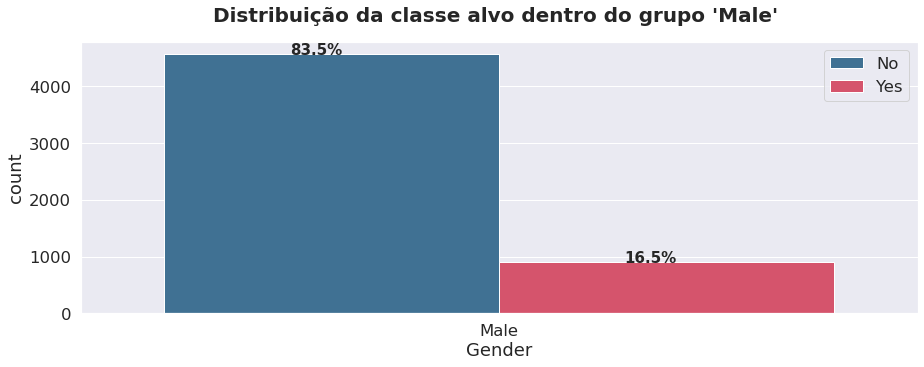

In [17]:
countplot_group(column="Gender", df=df,group="Male")

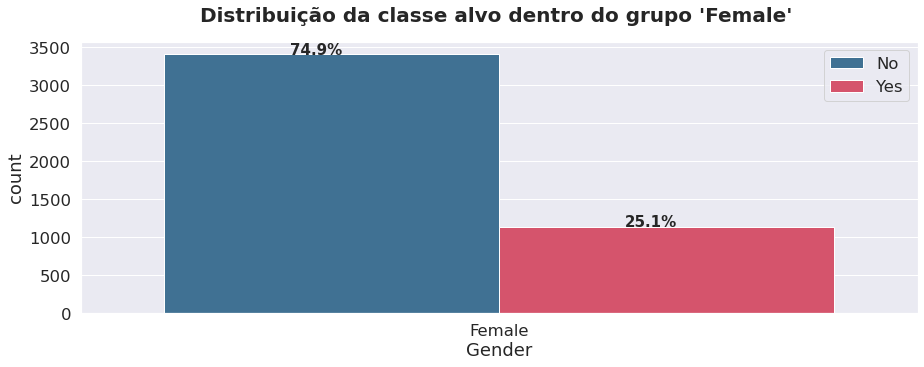

In [18]:
countplot_group(column="Gender", df=df,group="Female")

- A taxa de cancelamento ("churn") é cerca de 9% maior entre clientes do gênero feminino.
- Isto pode indicar a necessidade de uma ação direcionada para esse público.

## Distribuição da classe alvo por país

In [19]:
df["Geography"].value_counts().to_frame()

,Geography
France,5014
Germany,2509
Spain,2477


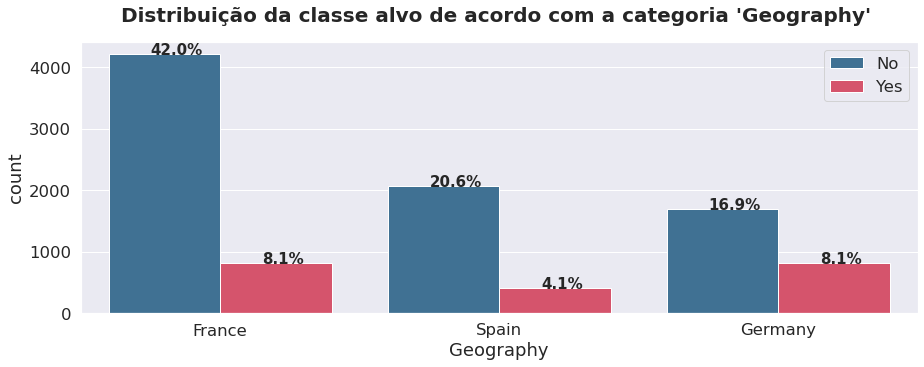

In [20]:
countplot(column="Geography",df=df)

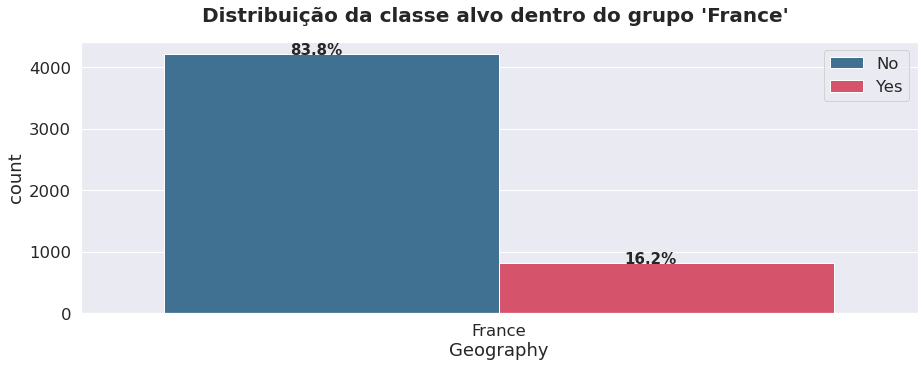

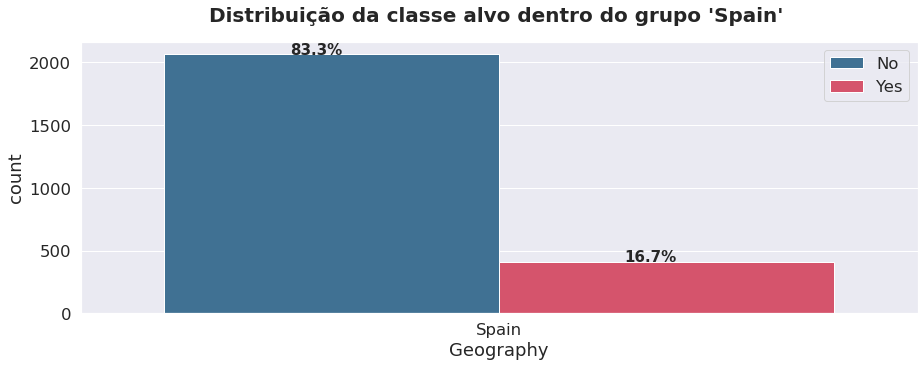

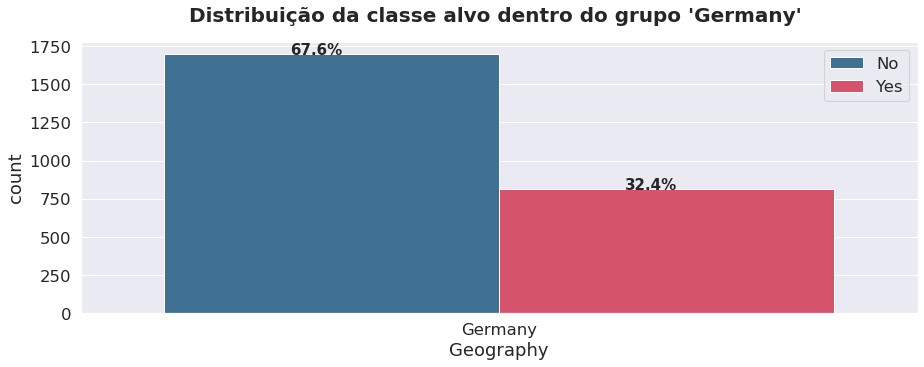

In [21]:
for country in list(df["Geography"].unique()):
    countplot_group(column="Geography", df=df, group=country)

<font color = red>

- Acrescentar observações e insights

## Distribuição da classe alvo entre clientes que possuem cartão de crédito

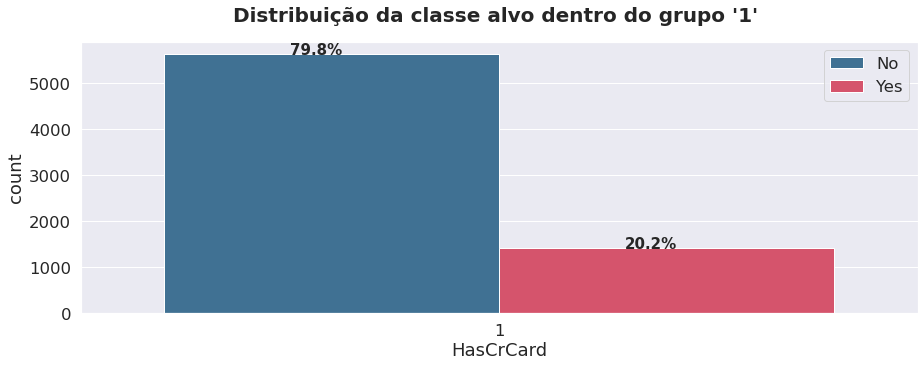

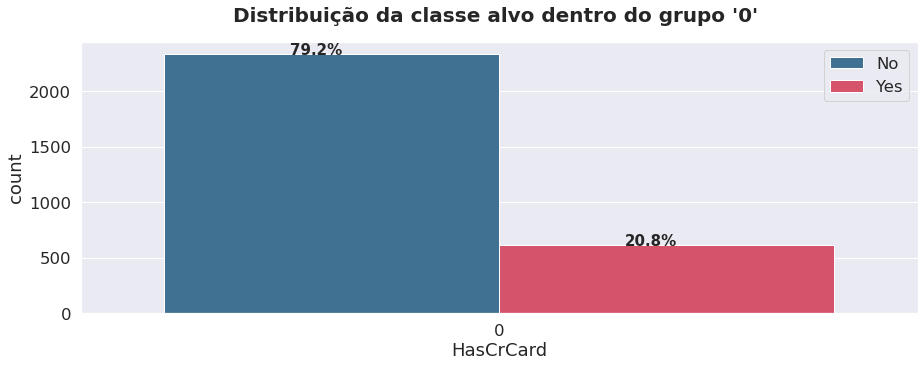

In [22]:
for group in list(df["HasCrCard"].unique()):
    countplot_group(column="HasCrCard", df=df, group=group)

- O fato de o cliente possuir cartão de crédito não parece afetar diretamente o abandono dos sevirços ("churn")

## Distribuição da classe alvo por número de produtos

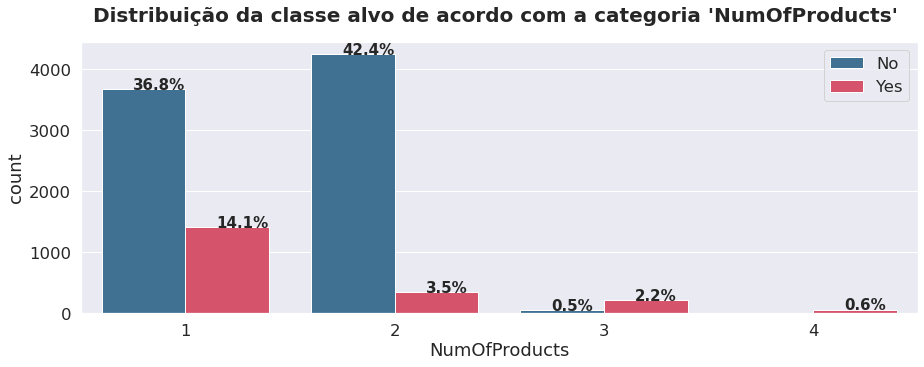

In [23]:
countplot(column="NumOfProducts", df=df)

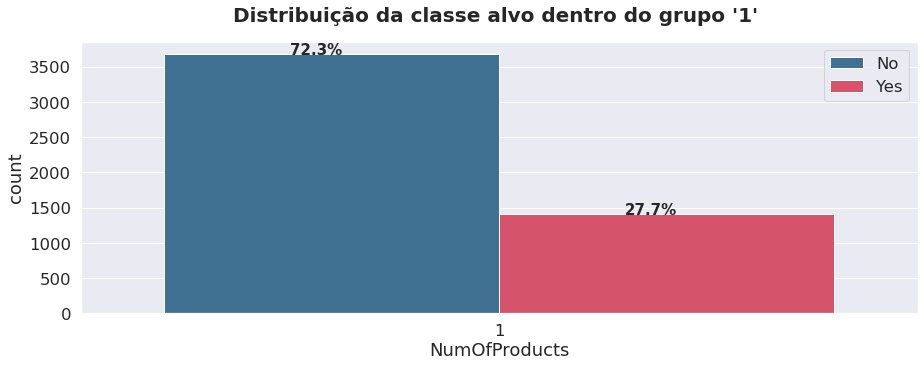

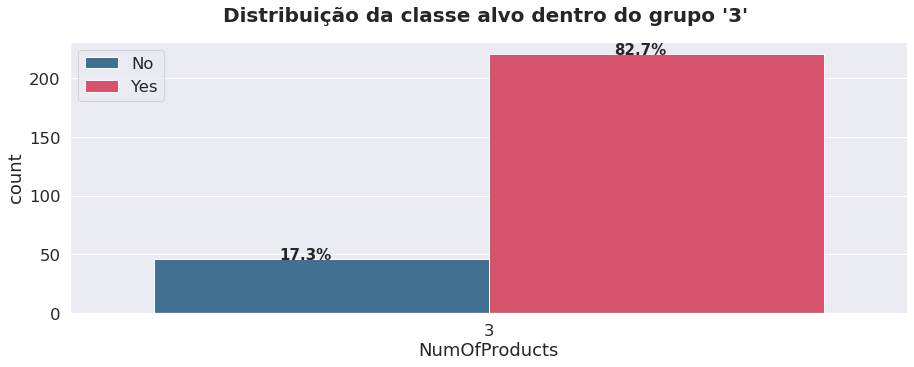

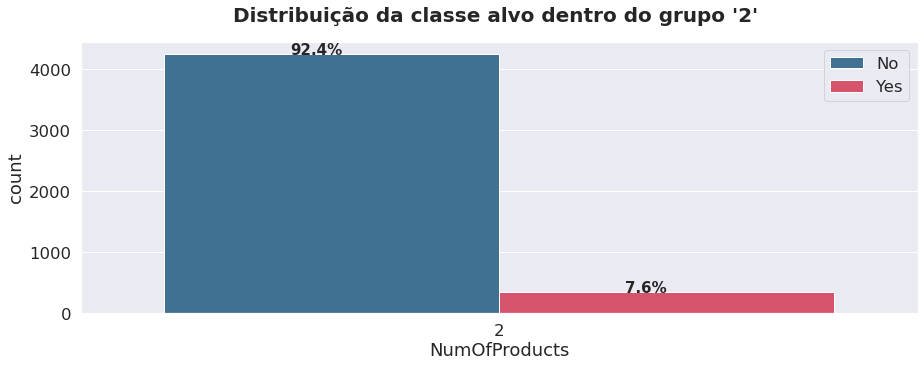

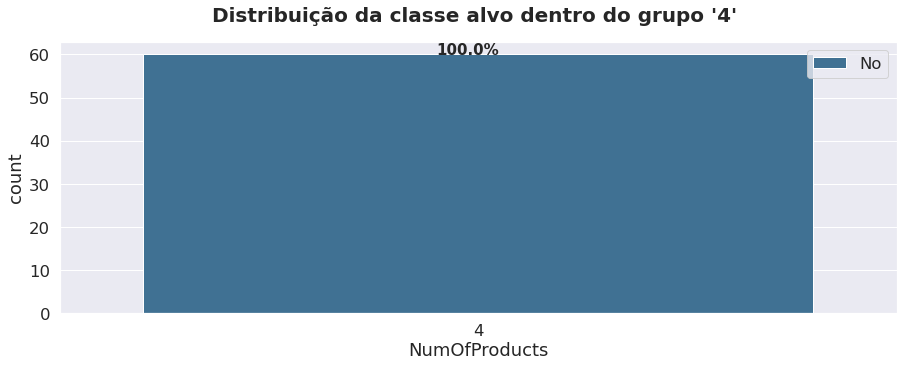

In [24]:
for group in list(df["NumOfProducts"].unique()):
    countplot_group(column="NumOfProducts", df=df, group=group)

<font color = red>

- Acrescentar observações
Embora 100% das pessoas com 4 produtos terminam dando 'churn', no total dos dados são apenas 0,6%. Seria ousado dizer que 4 produtos implicam churn

## Distribuição da classe alvo por membros ativos/inativos

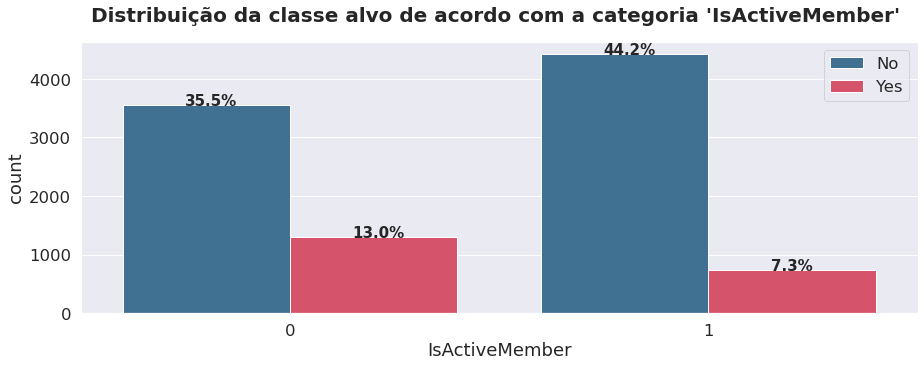

In [25]:
countplot(column="IsActiveMember", df=df)

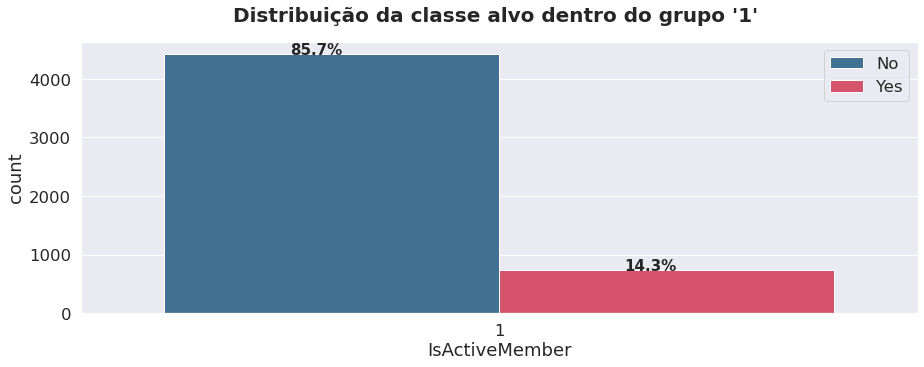

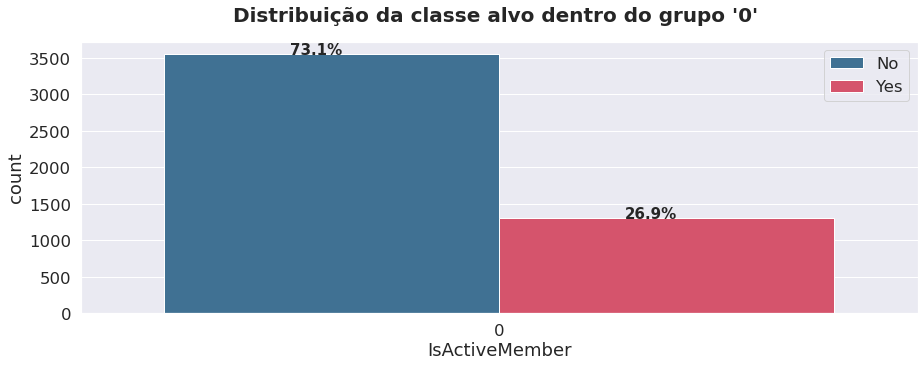

In [26]:
for group in list(df["IsActiveMember"].unique()):
    countplot_group(column="IsActiveMember", df=df, group=group)

<font color = red>

- Acrescentar observações  

## Distribuição por 'Tenure'

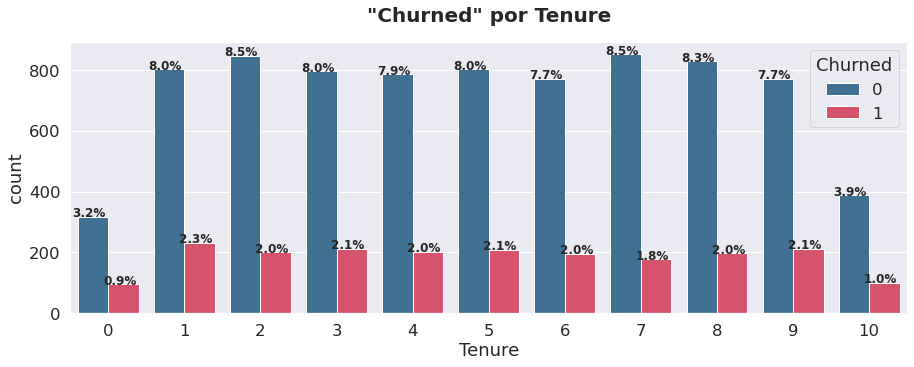

In [27]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x="Tenure", data=df, hue=alvo, palette=cores)
for value in ax.patches:
    percentage = "{:.1f}%".format(100*value.get_height()/len(df["Tenure"]))
    x = value.get_x() + value.get_width() / 2 - 0.05
    y = value.get_y() + value.get_height()
    ax.annotate(percentage, (x,y), fontweight="black",size=12, ha="center")

plt.title(f'"{alvo}" por Tenure',fontweight="black",size=20,pad=20)
plt.show()

<font color = red>

- Acrescentar observações  

## Função para plotar gráficos de variáveis contínuas

In [28]:
def continuous_plot(column, df):
    plt.figure(figsize=(13,6))
    plt.subplot(1,2,1)
    sns.histplot(x=column,hue=alvo,data=df,kde=True, palette=cores)
    plt.title(f"Distribuição da coluna {column} por Churn",fontweight="black",pad=20,size=15)
    plt.legend(labels=['Yes','No'])
    
    plt.subplot(1,2,2)
    sns.boxplot(x=df[alvo],y=df[column], palette=cores)
    plt.title(f"Distribuição da coluna {column} Churn",fontweight="black",pad=20,size=15)
    plt.tight_layout()
    plt.show()

## Distribuição da coluna idade ("Age")

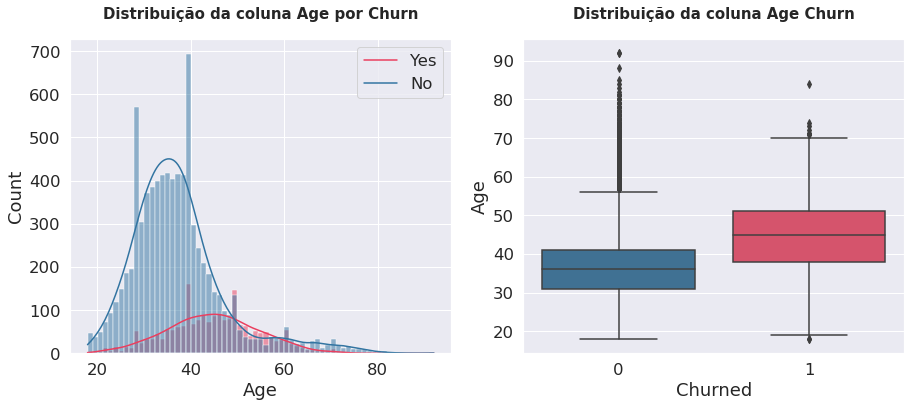

In [29]:
continuous_plot(column="Age", df=df)

In [30]:
df["Age"].skew()

1.0113202630234552

In [31]:
mean_yes = df[df["Churned"] == 1]["Age"].mean()
mean_no = df[df["Churned"] == 0]["Age"].mean()
std_yes = df[df["Churned"] == 1]["Age"].std()
std_no = df[df["Churned"] == 0]["Age"].std()

print(f"Média de idade (Churned = 'No'): {mean_no:.2f} | desvio padrão: {std_no:.2f}")

print(f"Média de idade (Churned = 'Yes'): {mean_yes:.2f} |  desvio padrão: {std_yes:.2f}")

Média de idade (Churned = 'No'): 37.41 | desvio padrão: 10.13
Média de idade (Churned = 'Yes'): 44.84 |  desvio padrão: 9.76


<font color = red>

- Acrescentar observações
- A distribuição de idades apresenta um perfil assimétrico à direita

## Distribuição da coluna 'CreditScore'

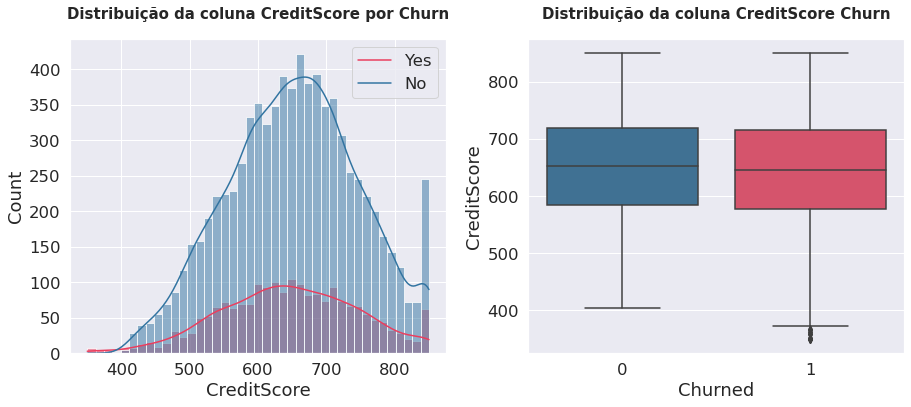

In [32]:
continuous_plot(column="CreditScore", df=df)

<font color = red>

- Acrescentar observações  
- Excetuando os clientes com Score muito alto, a distribuição de 'CreditScore' parece indicar que há pouca influência na classificação

## Distribuição da coluna 'Balance'

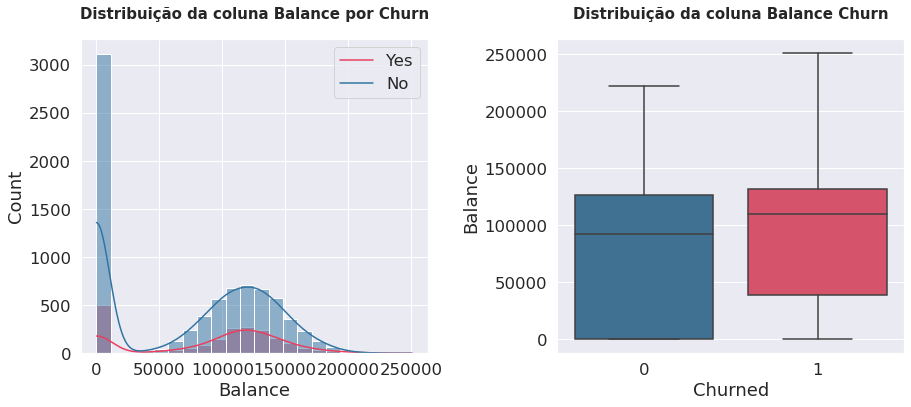

In [33]:
continuous_plot(column="Balance", df=df)

<font color = red>

- Acrescentar observações  
- Excetuando os clientes com balanço nulo, o restante parece seguir uma distribuição normal.

## Distribuição da variável 'EstimatedSalary'

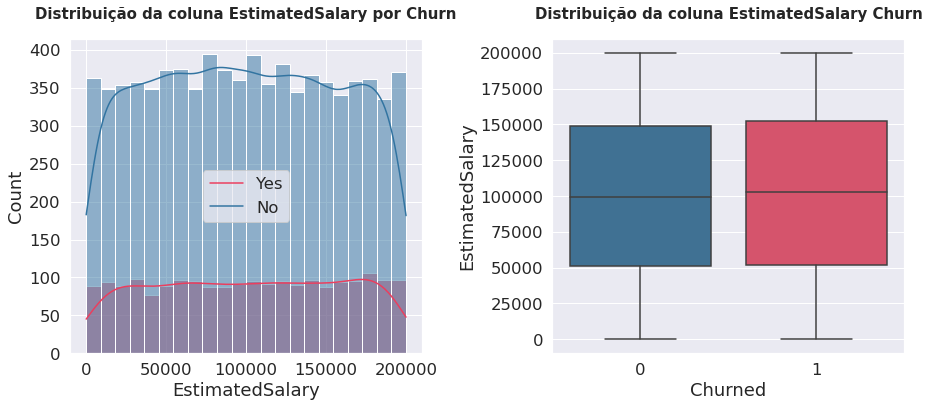

In [34]:
continuous_plot(column="EstimatedSalary", df=df)

<font color = red>

- Acrescentar observações  
- Os gráficos indicam haver pouca influência de 'EstimatedSalary' na classificação

# Pré-processamento

### Gerando "dummies" para variáveis categóricas

In [35]:
categoric_cols = [
    "Geography",
    "Gender"
           ]

In [36]:
df_prep = pd.get_dummies(columns=categoric_cols, data = df)

### Separando features e variável alvo

In [37]:
X = df_prep.drop(columns = alvo)
y = df_prep[alvo]

# Criando tabela de resultados

In [38]:
results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1-score', 'ROC-AUC'])
results

,model,accuracy,precision,recall,f1-score,ROC-AUC


# Realizando experimentos iniciais com alguns modelos

## Regressão Logística

In [39]:
# Colocando os dados na mesma escala
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Separando dados de teste e de treino
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

# Balanceamento da classe minoritária na base de treino
smt = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

# Treinamento
modelo = LogisticRegression()
reg  = modelo.fit(X_train_resampled, y_train_resampled)

# modeloB = LogisticRegression()
# regB = modeloB.fit(X_train, y_train)

### Avaliação

In [40]:
y_pred = reg.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred, digits=3))

[[1163  444]
 [ 115  278]]
              precision    recall  f1-score   support

           0      0.910     0.724     0.806      1607
           1      0.385     0.707     0.499       393

    accuracy                          0.721      2000
   macro avg      0.648     0.716     0.652      2000
weighted avg      0.807     0.721     0.746      2000



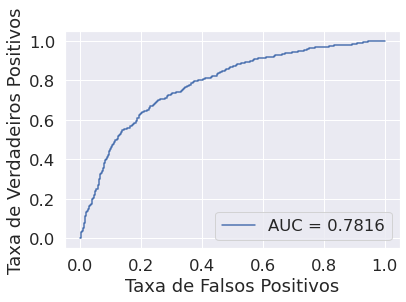

In [41]:
# Calculando as probabilidades previstas pelo modelo
y_pred_prob = reg.predict_proba(X_test)
probab_y_pred_ser_1 = y_pred_prob[:,1]

taxa_falsos_positivos, taxa_verdadeiros_positivos, _ = roc_curve(y_test,  probab_y_pred_ser_1)
auc = roc_auc_score(y_test, probab_y_pred_ser_1)

plt.plot(taxa_falsos_positivos,taxa_verdadeiros_positivos, label = "AUC = " + str(round(auc,4)))
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Positivos')
plt.legend(loc=4)
plt.show()

<font color = red>

- Acrescentar observações
O modelo apresenta métricas de precisão e recall afastadas entre sim, e um f1 baixo. Como primeiro modelo de aproximação, não parece ser um bom para explicar os dados. A regressão logística é a primeira opção para resultados categóricos.

### Adicionar à tabela de resultados

In [42]:
results = results.append({
    'model':     'Regressão Logística',
    'accuracy':  accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall':    recall_score(y_test, y_pred),
    'f1-score': f1_score(y_test, y_pred),
    'ROC-AUC': auc
}, ignore_index=True)
results

,model,accuracy,precision,recall,f1-score,ROC-AUC
0,Regressão Logística,0.7205,0.385042,0.707379,0.498655,0.781595


## 'N' vizinhos mais próximos (KNN)

In [43]:
# Colocando os dados na mesma escala
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X)

# Separando dados de teste e de treino
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

# Balanceamento da classe minoritária na base de treino
smt = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

# Treinamento
knn = KNeighborsClassifier()
knn.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier()

### Avaliação

In [44]:
# Predição (teste)
y_pred_knn = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred_knn))
print(classification_report(y_test, y_pred_knn, digits=3))

[[1211  396]
 [ 146  247]]
              precision    recall  f1-score   support

           0      0.892     0.754     0.817      1607
           1      0.384     0.628     0.477       393

    accuracy                          0.729      2000
   macro avg      0.638     0.691     0.647      2000
weighted avg      0.793     0.729     0.750      2000



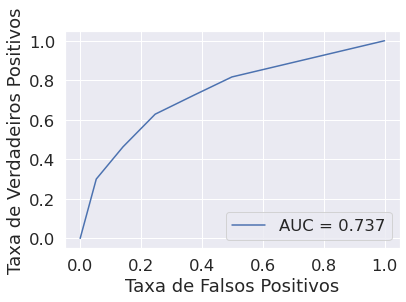

In [45]:
# Calculando as probabilidades previstas pelo modelo
y_pred_knn_prob = knn.predict_proba(X_test)

probab_y_pred_knn_ser_1 = y_pred_knn_prob[:,1]

taxa_falsos_positivos_knn, taxa_verdadeiros_positivos_knn, _ = roc_curve(y_test,  probab_y_pred_knn_ser_1)
auc_knn = roc_auc_score(y_test, probab_y_pred_knn_ser_1)

plt.plot(taxa_falsos_positivos_knn,taxa_verdadeiros_positivos_knn, label = "AUC = " + str(round(auc_knn,4)))
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Positivos')
plt.legend(loc=4)
plt.show()

<font color = red>

- Acrescentar observações
Comparado com o modelo de regressão logística, o KNN apresenta piores indicadores. É mais provável que seja descartado como modelo para aprimorar.

### Adicionar à tabela de resultados

In [46]:
results = results.append({
    'model':     'KNN',
    'accuracy':  accuracy_score(y_test, y_pred_knn),
    'precision': precision_score(y_test, y_pred_knn),
    'recall':    recall_score(y_test, y_pred_knn),
    'f1-score':  f1_score(y_test, y_pred_knn),
    'ROC-AUC': auc_knn
}, ignore_index=True)
results

,model,accuracy,precision,recall,f1-score,ROC-AUC
0,Regressão Logística,0.7205,0.385042,0.707379,0.498655,0.781595
1,KNN,0.729,0.384137,0.628499,0.476834,0.737019


## Floresta Aleatória

In [47]:
# Colocando os dados na mesma escala
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X)

# Separando dados de teste e de treino
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

# Balanceamento da classe minoritária na base de treino
smt = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

# Treinamento
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

### Avaliação

[[1432  175]
 [ 152  241]]
              precision    recall  f1-score   support

           0      0.904     0.891     0.898      1607
           1      0.579     0.613     0.596       393

    accuracy                          0.837      2000
   macro avg      0.742     0.752     0.747      2000
weighted avg      0.840     0.837     0.838      2000



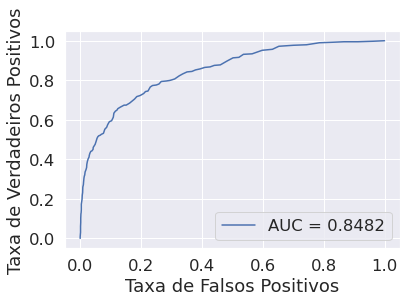

In [48]:
# Gerando predições
y_pred_rfc = rfc.predict(X_test)
print(confusion_matrix(y_test,y_pred_rfc))
print(classification_report(y_test, y_pred_rfc, digits=3))

# Calculando as probabilidades previstas pelo modelo
y_pred_rfc_prob = rfc.predict_proba(X_test)
probab_y_pred_rfc_ser_1 = y_pred_rfc_prob[:,1]

taxa_falsos_positivos_rfc, taxa_verdadeiros_positivos_rfc, _ = roc_curve(y_test,  probab_y_pred_rfc_ser_1)
auc_rfc = roc_auc_score(y_test, probab_y_pred_rfc_ser_1)

plt.plot(taxa_falsos_positivos_rfc,taxa_verdadeiros_positivos_rfc, label = "AUC = " + str(round(auc_rfc,4)))
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Positivos')
plt.legend(loc=4)
plt.show()

<font color = red>

- Acrescentar observações

### Adicionar à tabela de resultados

In [49]:
results = results.append({
    'model':     'Floresta Aleatória',
    'accuracy':  accuracy_score(y_test, y_pred_rfc),
    'precision': precision_score(y_test, y_pred_rfc),
    'recall':    recall_score(y_test, y_pred_rfc),
    'f1-score':  f1_score(y_test, y_pred_rfc),
    'ROC-AUC':   auc_rfc
}, ignore_index=True)
results

,model,accuracy,precision,recall,f1-score,ROC-AUC
0,Regressão Logística,0.7205,0.385042,0.707379,0.498655,0.781595
1,KNN,0.729,0.384137,0.628499,0.476834,0.737019
2,Floresta Aleatória,0.8365,0.579327,0.613232,0.595797,0.848163


# Otimizando hiperparâmetros do modelo escolhido ("Floresta Aleatória")

In [50]:
# Colocando os dados na mesma escala
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X)

# Separando dados de teste e de treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balanceamento da classe minoritária na base de treino
smt = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

In [51]:
%%time

rfc = RandomForestClassifier(random_state=42)

params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, 50, 100, 125],
    'min_samples_split': [2, 3, 5, 10, 15],
    'max_features': ['sqrt', 'log2', None],
}

grid_search = GridSearchCV(estimator=rfc, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

CPU times: user 2.74 s, sys: 369 ms, total: 3.11 s
Wall time: 3min 6s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 50, 100, 125],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 3, 5, 10, 15]},
             scoring='accuracy')

In [52]:
best_params = grid_search.best_params_
print('Melhores parâmetros: ', best_params)

accuracy = grid_search.score(X_test, y_test)
print('Score: ', accuracy)

Melhores parâmetros:  {'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2}
Score:  0.862


In [53]:
# melhores_param = {'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2}
# rfc_gs = RandomForestClassifier(**melhores_param)
# rfc_gs.fit(X_train_resampled, y_train_resampled)

In [54]:
rfc_gs = RandomForestClassifier(**best_params)
rfc_gs.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt')

### Avaliação

[[1489  118]
 [ 172  221]]
              precision    recall  f1-score   support

           0      0.896     0.927     0.911      1607
           1      0.652     0.562     0.604       393

    accuracy                          0.855      2000
   macro avg      0.774     0.744     0.758      2000
weighted avg      0.848     0.855     0.851      2000



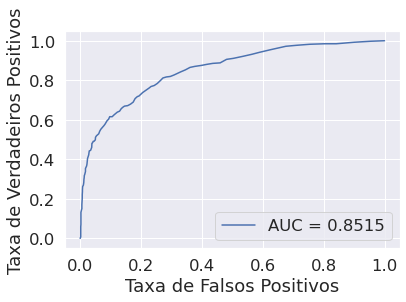

In [55]:
y_pred_rfc_gs = rfc_gs.predict(X_test)
print(confusion_matrix(y_test,y_pred_rfc_gs))
print(classification_report(y_test, y_pred_rfc_gs, digits=3))

# Calculando as probabilidades previstas pelo modelo
y_pred_rfc_gs_prob = rfc_gs.predict_proba(X_test)
probab_y_pred_rfc_gs_ser_1 = y_pred_rfc_gs_prob[:,1]

taxa_falsos_positivos_rfc_gs, taxa_verdadeiros_positivos_rfc_gs, _ = roc_curve(y_test,  probab_y_pred_rfc_gs_ser_1)
auc_rfc_gs = roc_auc_score(y_test, probab_y_pred_rfc_gs_ser_1)

plt.plot(taxa_falsos_positivos_rfc_gs,taxa_verdadeiros_positivos_rfc_gs, label = "AUC = " + str(round(auc_rfc_gs,4)))
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Positivos')
plt.legend(loc=4)
plt.show()

### Adicionar à tabela de resultados

In [56]:
results = results.append({
    'model':     'Floresta Aleatória com GridSearch',
    'accuracy':  accuracy_score(y_test, y_pred_rfc_gs),
    'precision': precision_score(y_test, y_pred_rfc_gs),    
    'recall':    recall_score(y_test, y_pred_rfc_gs),
    'f1-score':  f1_score(y_test, y_pred_rfc_gs),
    'ROC-AUC': auc_rfc_gs
}, ignore_index=True)
results

,model,accuracy,precision,recall,f1-score,ROC-AUC
0,Regressão Logística,0.7205,0.385042,0.707379,0.498655,0.781595
1,KNN,0.729,0.384137,0.628499,0.476834,0.737019
2,Floresta Aleatória,0.8365,0.579327,0.613232,0.595797,0.848163
3,Floresta Aleatória com GridSearch,0.855,0.651917,0.562341,0.603825,0.851475


# Feature Engineering

## Colocando a variável 'idade' em escala logarítmica

In [57]:
df["Age"].skew()

1.0113202630234552

In [58]:
df["Log_Age"] = np.log(df["Age"])

In [59]:
df["Log_Age"].skew()

0.182020112559587

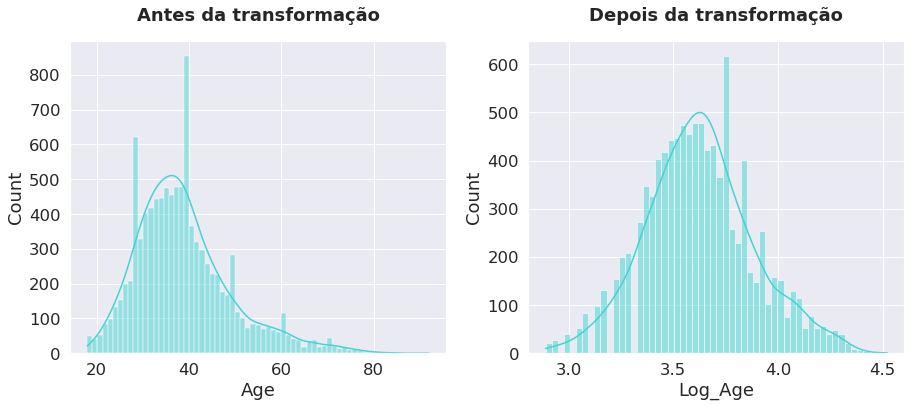

In [60]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
sns.histplot(df["Age"], kde=True, color="#42D4D4")
plt.title("Antes da transformação",fontweight="black",size=18,pad=20)

plt.subplot(1,2,2)
sns.histplot(df["Log_Age"], kde=True, color="#42D4D4")
plt.title("Depois da transformação",fontweight="black",size=18,pad=20)
plt.tight_layout()
plt.show()

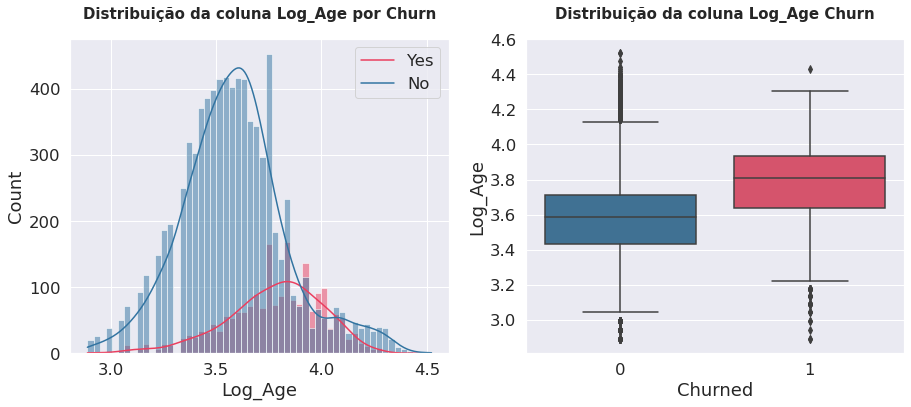

In [61]:
continuous_plot(column="Log_Age", df=df)

### Dividindo a coluna 'NumOfProducts' em categorias 

In [62]:
condicoes = [(df["NumOfProducts"]==1), (df["NumOfProducts"]==2), (df["NumOfProducts"]>2)]
valores =     ["One product","Two Products","More Than 2 Products"]

In [63]:
df["TotalProducts"] = np.select(condicoes,valores)

### Dividindo a variável 'Balance' em classes  

In [64]:
condicoes_balance = [(df["Balance"]==0), (df["Balance"]>0)]
valores_balance = ["Zero Balance","More Than zero Balance"]

In [65]:
df["AccountBalance"] = np.select(condicoes_balance, valores_balance)

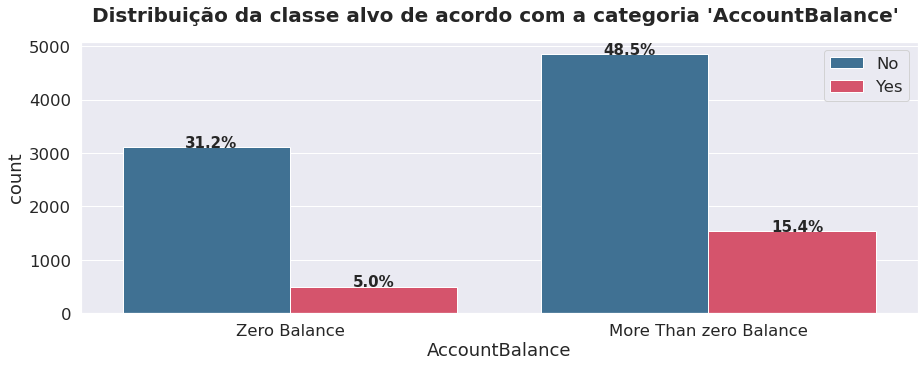

In [66]:
countplot("AccountBalance", df=df)

### Testando o modelo com as variáveis alteradas

### Gerando "dummies" para variáveis categóricas

In [67]:
categoric_cols_2 = [
    "Geography",
    "Gender",
    "TotalProducts",
    "AccountBalance"
           ]

In [68]:
df_prep_2 = pd.get_dummies(columns=categoric_cols_2, data = df)
df_prep_2.drop(columns=["Age", "NumOfProducts", "Balance"], inplace=True)

### Separando features e variável alvo

In [69]:
X2 = df_prep_2.drop(columns = "Churned")
y2 = df_prep_2["Churned"]

In [70]:
# Colocando os dados na mesma escala 
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X2)

# Separando dados de teste e de treino
X_train, X_test, y_train, y_test = train_test_split(X_std, y2, test_size=0.2, random_state=42)

# Balanceamento da classe minoritária na base de treino 
smt = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

In [71]:
# melhores_param ={'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2}
# rfc_fe = RandomForestClassifier(**melhores_param)
# rfc_fe.fit(X_train_resampled, y_train_resampled)

In [72]:
rfc_fe = RandomForestClassifier(**best_params)
rfc_fe.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt')

### Avaliação

[[1406  201]
 [ 156  237]]
              precision    recall  f1-score   support

           0      0.900     0.875     0.887      1607
           1      0.541     0.603     0.570       393

    accuracy                          0.822      2000
   macro avg      0.721     0.739     0.729      2000
weighted avg      0.830     0.822     0.825      2000



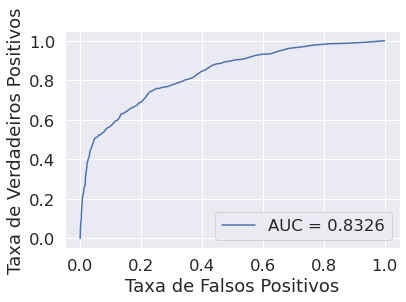

In [73]:
y_pred_rfc_fe = rfc_fe.predict(X_test)
print(confusion_matrix(y_test,y_pred_rfc_fe))
print(classification_report(y_test, y_pred_rfc_fe, digits=3))

# Calculando as probabilidades previstas pelo modelo
y_pred_rfc_fe_prob = rfc_fe.predict_proba(X_test)
probab_y_pred_rfc_fe_ser_1 = y_pred_rfc_fe_prob[:,1]

taxa_falsos_positivos_rfc_fe, taxa_verdadeiros_positivos_rfc_fe, _ = roc_curve(y_test,  probab_y_pred_rfc_fe_ser_1)
auc_rfc_fe = roc_auc_score(y_test, probab_y_pred_rfc_fe_ser_1)

plt.plot(taxa_falsos_positivos_rfc_fe,taxa_verdadeiros_positivos_rfc_fe, label = "AUC = " + str(round(auc_rfc_fe,4)))
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Positivos')
plt.legend(loc=4)
plt.show()

### Adicionar à tabela de resultados

In [74]:
results = results.append({
    'model':     'Floresta Aleatória com tratamento de features',
    'accuracy':  accuracy_score(y_test, y_pred_rfc_fe),
    'precision': precision_score(y_test, y_pred_rfc_fe),
    'recall':    recall_score(y_test, y_pred_rfc_fe),
    'f1-score':  f1_score(y_test, y_pred_rfc_fe),
    'ROC-AUC': auc_rfc_fe
}, ignore_index=True)
results

,model,accuracy,precision,recall,f1-score,ROC-AUC
0,Regressão Logística,0.7205,0.385042,0.707379,0.498655,0.781595
1,KNN,0.729,0.384137,0.628499,0.476834,0.737019
2,Floresta Aleatória,0.8365,0.579327,0.613232,0.595797,0.848163
3,Floresta Aleatória com GridSearch,0.855,0.651917,0.562341,0.603825,0.851475
4,Floresta Aleatória com tratamento de features,0.8215,0.541096,0.603053,0.570397,0.832622


# Conclusões

## Comparação entre modelos

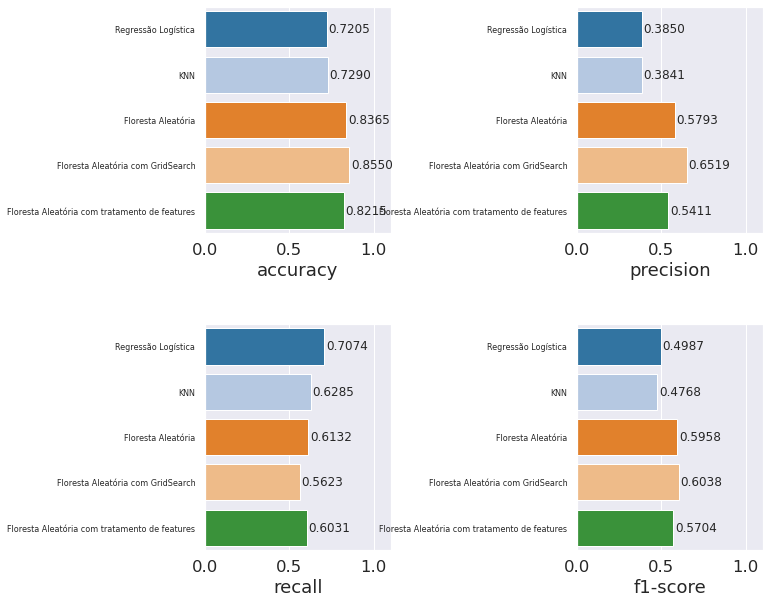

In [75]:
columns = ['accuracy', 'precision', 'recall', 'f1-score']


gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,1])
gs.update(wspace = 1, hspace = 0.4)
fig = plt.figure(figsize=(10,10))

for i, var in enumerate(columns):
  ax = plt.subplot(gs[i])

  sns.barplot(data=results, y='model', x=var,  palette='tab20')
  for p in ax.patches:
    width = p.get_width()
    ax.text(width+0.01,
            p.get_y() + p.get_height() / 2,
            '{:1.4f}'.format(width),
            ha='left',
            va='center',
            fontsize=12)
  plt.xlim(0,1.1)
  ax.tick_params(axis='y', labelsize=8)
  ax.yaxis.label.set_visible(False)


warnings.filterwarnings('default')

<font color = red>

- ponto 1
- ponto 2
- ponto 3
- etc.

## Impacto relativo das features no resultado 

In [76]:
imp_df = pd.DataFrame({"Features": X.columns,
                       "Importância": rfc_gs.feature_importances_})

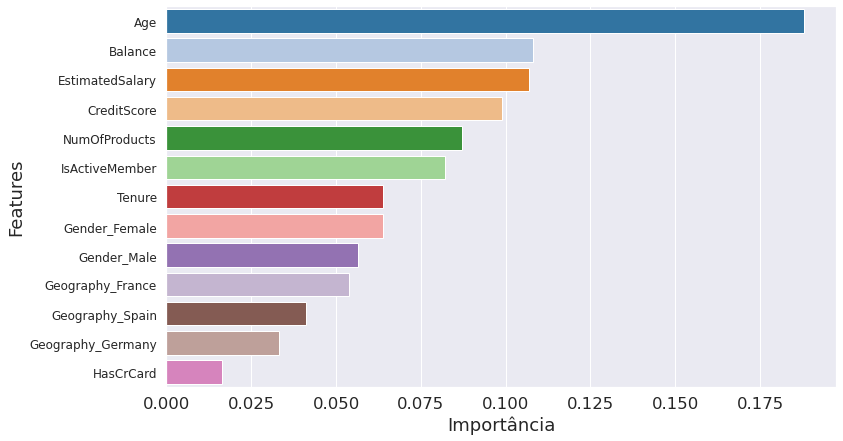

In [81]:
features = imp_df.sort_values(by="Importância",ascending=False)

plt.figure(figsize=(12,7))
sns.barplot(x="Importância", y="Features", data=features, palette='tab20')
plt.yticks(size=12)
plt.show()